In [45]:
###########################
# data libraries
###########################
import pandas as pd
import numpy as np

###########################
# plot libraries
###########################
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams

###########################
# data generation
###########################
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [46]:
## Read data
train = pd.read_csv("train.csv")
y = train[['Consumer_type']]
X = train[['Year', 'Month', 'Consumption', 'Consumer_number', 'Installation_zone']]

## Encode data
enc = OrdinalEncoder(dtype=np.int16)
enc.fit(X)

enc_label = OrdinalEncoder(dtype=np.int16)
X[['Year', 'Month','Consumption' ,'Consumer_number', 'Installation_zone']]= enc.transform(X[['Year', 'Month','Consumption','Consumer_number', 'Installation_zone']])
print(y['Consumer_type'].unique())
y[['Consumer_type']] = enc_label.fit_transform(y[['Consumer_type']])
print(y.Consumer_type.unique())
y = y.Consumer_type

test = X


test = X
## Scale data
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

## Create data and label
data = pd.DataFrame(X, columns=['Year', 'Month', 'Consumption', 'Consumer_number', 'Installation_zone'])
label = y.values

# One hot encode labels
one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_labels = one_hot_encoder.fit_transform(np.array(label).reshape(-1, 1))

['domestic' 'industrial' 'rural commercial' 'construction'
 'low income families' 'rural domestic' 'rural expansion']
[1 2 4 0 3 5 6]


/tmp/ipykernel_4060/4035412387.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[['Year', 'Month','Consumption' ,'Consumer_number', 'Installation_zone']]= enc.transform(X[['Year', 'Month','Consumption','Consumer_number', 'Installation_zone']])
/tmp/ipykernel_4060/4035412387.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[['Consumer_type']] = enc_label.fit_transform(y[['Consumer_type']])
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was ren

In [47]:
test.Year.unique()

array([0, 1, 2, 3, 4, 5, 6], dtype=int16)

In [48]:
# Constants
NOISE_DIM = 100
NUM_CLASSES = 7
NUM_FEATURES = 5
BATCH_SIZE = 64
TRAINING_STEPS = 500

# Generator
def create_generator():
    noise_input = Input(shape=(NOISE_DIM,))
    class_input = Input(shape=(NUM_CLASSES,))
    merged_input = Concatenate()([noise_input, class_input])
    hidden = Dense(128, activation='relu')(merged_input)
    output = Dense(NUM_FEATURES, activation='linear')(hidden)
    model = Model(inputs=[noise_input, class_input], outputs=output)
    return model

# Discriminator
def create_discriminator():
    data_input = Input(shape=(NUM_FEATURES,))
    class_input = Input(shape=(NUM_CLASSES,))
    merged_input = Concatenate()([data_input, class_input])
    hidden = Dense(128, activation='relu')(merged_input)
    output = Dense(1, activation='sigmoid')(hidden)
    model = Model(inputs=[data_input, class_input], outputs=output)
    return model

# cGAN
def create_cgan(generator, discriminator):
    noise_input = Input(shape=(NOISE_DIM,))
    class_input = Input(shape=(NUM_CLASSES,))
    generated_data = generator([noise_input, class_input])
    validity = discriminator([generated_data, class_input])
    model = Model(inputs=[noise_input, class_input], outputs=validity)
    return model

In [49]:
# Create and compile the Discriminator
discriminator = create_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam())

# Create the Generator
generator = create_generator()

# Create the GAN
gan = create_cgan(generator, discriminator)

# Ensure that only the generator is trained
discriminator.trainable = False

gan.compile(loss='binary_crossentropy', optimizer=Adam())

In [50]:
# Train GAN
dl = []
gl = []
for step in range(TRAINING_STEPS):
    # Select a random batch of real data with labels
    idx = np.random.randint(0, data.shape[0], BATCH_SIZE)
    real_batch = data.iloc[idx].values
    labels_batch = one_hot_labels[idx]

    # Generate a batch of new data
    noise = np.random.normal(0, 1, (BATCH_SIZE, NOISE_DIM))
    generated_batch = generator.predict([noise, labels_batch])

    # Train the discriminator
    real_loss = discriminator.train_on_batch([real_batch, labels_batch], np.ones((BATCH_SIZE, 1)))
    fake_loss = discriminator.train_on_batch([generated_batch, labels_batch], np.zeros((BATCH_SIZE, 1)))
    discriminator_loss = 0.5 * np.add(real_loss, fake_loss)

    # Train the generator
    generator_loss = gan.train_on_batch([noise, labels_batch], np.ones((BATCH_SIZE, 1)))
    dl.append(discriminator_loss)
    gl.append(generator_loss)
    if step % 2 == 0:
        print(f"Step: {step}, Discriminator Loss: {discriminator_loss}, Generator Loss: {generator_loss}")

2/2 [==============================] - 0s 3ms/step
Step: 0, Discriminator Loss: 0.7524538636207581, Generator Loss: 0.5068985223770142
2/2 [==============================] - 0s 3ms/step
Step: 2, Discriminator Loss: 0.7327969372272491, Generator Loss: 0.5002732276916504
2/2 [==============================] - 0s 3ms/step
Step: 4, Discriminator Loss: 0.7024102807044983, Generator Loss: 0.5364589691162109
2/2 [==============================] - 0s 4ms/step
Step: 6, Discriminator Loss: 0.6913334280252457, Generator Loss: 0.5414149761199951
2/2 [==============================] - 0s 4ms/step
Step: 8, Discriminator Loss: 0.6519756019115448, Generator Loss: 0.5895926356315613
2/2 [==============================] - 0s 2ms/step
Step: 10, Discriminator Loss: 0.6470052599906921, Generator Loss: 0.5890511274337769
2/2 [==============================] - 0s 3ms/step
Step: 12, Discriminator Loss: 0.6264240890741348, Generator Loss: 0.6176304817199707
2/2 [==============================] - 0s 3ms/step
St

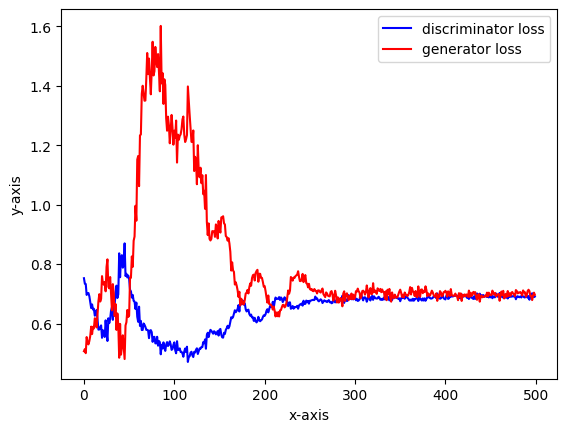

In [51]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(dl, label='discriminator loss', color='blue', linestyle='-')
plt.plot(gl, label='generator loss', color='red', linestyle='-')

plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.legend()

In [52]:
def generate_data(generator, data_class, num_instances):
    one_hot_class = one_hot_encoder.transform(np.array([[data_class]]))
    noise = np.random.normal(0, 1, (num_instances, NOISE_DIM))
    generated_data = generator.predict([noise, np.repeat(one_hot_class, num_instances, axis=0)])
    return pd.DataFrame(generated_data, columns=['Year', 'Month', 'Consumption', 'Consumer_number', 'Installation_zone'])

In [53]:
generated_data = generate_data(generator, 1, 40)
print(generated_data)

2/2 [==============================] - 0s 3ms/step
        Year     Month  Consumption  Consumer_number  Installation_zone
0   0.714042  0.216750     0.078668         0.365696           0.610488
1   0.647615  0.429212     0.015256         0.708676           0.660444
2   0.797087  0.797765     0.094022         1.001881           0.628598
3   0.435841  0.354080     0.083072         0.074430           0.384383
4   0.526893  0.240782     0.119614         0.402331           0.459051
5   0.735353  0.397003    -0.055848         0.609335           0.176069
6   0.345009  0.593901     0.051569         0.338708           0.322092
7   0.529837  0.257777    -0.137855         0.057990           0.314130
8   0.435255  0.595488     0.185457         0.482714           0.134296
9   0.955233  0.571221     0.054691         0.544749           0.360056
10  0.566216  0.744195     0.120530         0.477023           0.322315
11  0.533047  0.549443     0.189889         0.570446           0.626547
12  0.568205 

In [55]:
# Generate 50 instances for each class
# ['domestic' 'industrial' 'rural commercial' 'construction'
#  'low income families' 'rural domestic' 'rural expansion']
# [1 2 4 0 3 5 6]

synthetic_data_class_0 = generate_data(generator, 0, 200000)
generated_data_clipped = np.clip(synthetic_data_class_0, 0, 1)
synthetic_data_scaled = pd.DataFrame(scaler.inverse_transform(generated_data_clipped), columns=['Year', 'Month','Consumption', 'Consumer_number', 'Installation_zone'])
synthetic_data = synthetic_data_scaled.round().astype(np.int16)
synthetic_data = enc.inverse_transform(synthetic_data)
NewDataFrame0 = pd.DataFrame(synthetic_data, columns=['Year', 'Month', 'Consumption', 'Consumer_number', 'Installation_zone'])
NewDataFrame0.insert(NewDataFrame0.columns.get_loc('Consumption'), "Consumer_type", 'construction')
print(NewDataFrame0.head())

synthetic_data_class_2 = generate_data(generator, 2, 180000)
generated_data_clipped = np.clip(synthetic_data_class_2, 0, 1)
synthetic_data_scaled = pd.DataFrame(scaler.inverse_transform(generated_data_clipped), columns=['Year', 'Month','Consumption', 'Consumer_number', 'Installation_zone'])
synthetic_data = synthetic_data_scaled.round().astype(np.int16)
synthetic_data = enc.inverse_transform(synthetic_data)
NewDataFrame2 = pd.DataFrame(synthetic_data, columns=['Year', 'Month', 'Consumption', 'Consumer_number', 'Installation_zone'])
NewDataFrame2.insert(NewDataFrame2.columns.get_loc('Consumption'), "Consumer_type", 'industrial')

synthetic_data_class_3 = generate_data(generator, 3, 203000)
generated_data_clipped = np.clip(synthetic_data_class_3, 0, 1)
synthetic_data_scaled = pd.DataFrame(scaler.inverse_transform(generated_data_clipped), columns=['Year', 'Month','Consumption', 'Consumer_number', 'Installation_zone'])
synthetic_data = synthetic_data_scaled.round().astype(np.int16)
synthetic_data = enc.inverse_transform(synthetic_data)
NewDataFrame3 = pd.DataFrame(synthetic_data, columns=['Year', 'Month', 'Consumption', 'Consumer_number', 'Installation_zone'])
NewDataFrame3.insert(NewDataFrame3.columns.get_loc('Consumption'), "Consumer_type", 'low income families')

synthetic_data_class_4 = generate_data(generator, 4, 200000)
generated_data_clipped = np.clip(synthetic_data_class_4, 0, 1)
synthetic_data_scaled = pd.DataFrame(scaler.inverse_transform(generated_data_clipped), columns=['Year', 'Month','Consumption', 'Consumer_number', 'Installation_zone'])
synthetic_data = synthetic_data_scaled.round().astype(np.int16)
synthetic_data = enc.inverse_transform(synthetic_data)
NewDataFrame4 = pd.DataFrame(synthetic_data, columns=['Year', 'Month', 'Consumption', 'Consumer_number', 'Installation_zone'])
NewDataFrame4.insert(NewDataFrame4.columns.get_loc('Consumption'), "Consumer_type", 'rural commercial')

synthetic_data_class_5 = generate_data(generator, 5, 160000)
generated_data_clipped = np.clip(synthetic_data_class_5, 0, 1)
synthetic_data_scaled = pd.DataFrame(scaler.inverse_transform(generated_data_clipped), columns=['Year', 'Month','Consumption', 'Consumer_number', 'Installation_zone'])
synthetic_data = synthetic_data_scaled.round().astype(np.int16)
synthetic_data = enc.inverse_transform(synthetic_data)
NewDataFrame5 = pd.DataFrame(synthetic_data, columns=['Year', 'Month', 'Consumption', 'Consumer_number', 'Installation_zone'])
NewDataFrame5.insert(NewDataFrame5.columns.get_loc('Consumption'), "Consumer_type", 'rural domestic')

synthetic_data_class_6 = generate_data(generator, 6, 203000)
generated_data_clipped = np.clip(synthetic_data_class_6, 0, 1)
synthetic_data_scaled = pd.DataFrame(scaler.inverse_transform(generated_data_clipped), columns=['Year', 'Month','Consumption', 'Consumer_number', 'Installation_zone'])
synthetic_data = synthetic_data_scaled.round().astype(np.int16)
synthetic_data = enc.inverse_transform(synthetic_data)
NewDataFrame6 = pd.DataFrame(synthetic_data, columns=['Year', 'Month', 'Consumption', 'Consumer_number', 'Installation_zone'])
NewDataFrame6.insert(NewDataFrame6.columns.get_loc('Consumption'), "Consumer_type", 'rural expansion')



6250/6250 [==============================] - 10s 2ms/step
   Year Month Consumer_type Consumption     Consumer_number  \
0  2016     5  construction           0  HXTW27159220813061   
1  2017     4  construction           0  KACY51026398172973   
2  2019     5  construction          35  DBRZ37213883240498   
3  2020     6  construction          68  NSNL75855216706785   
4  2017     4  construction           0  OCOJ78634676240808   

      Installation_zone  
0  Installation_zone 31  
1  Installation_zone 39  
2  Installation_zone 33  
3  Installation_zone 46  
4  Installation_zone 43  
6344/6344 [==============================] - 10s 2ms/step


In [56]:
NewData = pd.concat([NewDataFrame0, NewDataFrame2, NewDataFrame3,NewDataFrame4,NewDataFrame5,NewDataFrame6], ignore_index=True)
print(NewData.head())
NewData.to_csv('teste.csv', index=False)

   Year Month Consumer_type Consumption     Consumer_number  \
0  2016     5  construction           0  HXTW27159220813061   
1  2017     4  construction           0  KACY51026398172973   
2  2019     5  construction          35  DBRZ37213883240498   
3  2020     6  construction          68  NSNL75855216706785   
4  2017     4  construction           0  OCOJ78634676240808   

      Installation_zone  
0  Installation_zone 31  
1  Installation_zone 39  
2  Installation_zone 33  
3  Installation_zone 46  
4  Installation_zone 43  
